In [1]:
import data_prep

import pandas as pd
from pandas import DataFrame
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import scipy.stats as stats
from sklearn.decomposition import FactorAnalysis, PCA, KernelPCA, FastICA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import (
    mutual_info_classif,
    mutual_info_regression,
    f_classif,
)
from typing import List, Tuple, Optional

pd.set_option("display.max_columns", None)

In [2]:
data = pd.read_csv(data_prep.RAW_DATA_DIR / data_prep.TRAIN_DATA_FILENAME, sep=";", decimal=",")
quant_variables = data.drop(columns=['Class', 'Perform', 'Group']).columns.values
class_variable = 'Class'
perform_variable = 'Perform'
group_variable = 'Group'

### EDA utils

In [3]:
def make_class_distribution_plot(
    df: DataFrame, class_var: str, title: str, display_desc: bool = False
) -> None:
    r"""
    Plot the distribution of the given class variable in the dataframe.
    """

    plt.figure(figsize=(10, 4))
    plt.bar(
        df[class_var].value_counts().index,
        df[class_var].value_counts().values / len(df),
        color="grey",
        edgecolor="black",
    )
    plt.xticks(rotation=35)
    plt.ylabel("Frequency")
    if display_desc:
        plt.xlabel(class_var)
        plt.title(title)

    plt.show()


def make_histograms(
    df: DataFrame,
    quant_vars: List[str],
    title: str,
    subplots_shape: Optional[Tuple] = None,
    display_desc: bool = False,
    title_shift: float = 1,
    bins: int = 100,
    y_label: str = "PDF estimation",
) -> None:
    r"""
    Plot histograms of the given quantitative variables in the dataframe.
    """

    if subplots_shape is not None:
        num_rows, num_cols = subplots_shape
    else:
        num_plots = len(quant_vars)
        num_rows = (num_plots + 1) // 2
        num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 2 * num_rows))
    axes = np.atleast_2d(axes)
    plt.subplots_adjust(wspace=0.3, hspace=0.5)

    if display_desc:
        fig.suptitle(title, fontsize=16, y=title_shift)

    for i, var in enumerate(quant_vars):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        ax.hist(df[var], bins=bins, color="grey", edgecolor="black")
        ax.set_xlabel(var)
        ax.set_ylabel(y_label, fontsize=7)
        ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))

    plt.show()


def make_boxplots(
    df: DataFrame,
    quant_vars: List[str],
    title: str,
    subplots_shape: Optional[Tuple] = None,
    display_desc: bool = False,
    title_shift: float = 1,
) -> None:
    r"""
    Plot boxplots of the given quantitative variables in the dataframe.
    """

    if subplots_shape is not None:
        num_rows, num_cols = subplots_shape
    else:
        num_plots = len(quant_vars)
        num_rows = (num_plots + 1) // 2
        num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 2 * num_rows))
    axes = np.atleast_2d(axes)
    plt.subplots_adjust(wspace=0.3, hspace=0.5)

    if display_desc:
        fig.suptitle(title, fontsize=16, y=title_shift)

    for i, var in enumerate(quant_vars):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        ax.boxplot(
            df[var],
            vert=False,
            patch_artist=True,
            boxprops=dict(facecolor="grey", color="black"),
            whiskerprops=dict(color="black"),
            capprops=dict(color="black"),
            medianprops=dict(color="black"),
            flierprops=dict(marker="o", markersize=3, linestyle="none"),
        )
        ax.set_xlabel(var)
        ax.set_ylabel("Value")

    plt.show()

def make_boxplots_per_class(
    df: DataFrame,
    class_var: str,
    quant_var: str,
    title: str,
    display_desc: bool = False,
) -> None:
    r"""
    Plot boxplots of the given quantitative variables in the dataframe, grouped by cell type.
    """

    x = [group[quant_var].values for _, group in df.groupby(class_var, observed=True)]
    labels = df[class_var].unique()

    plt.figure(figsize=(12, 6))
    plt.boxplot(
        x=x,
        labels=labels,
        vert=False,
        patch_artist=True,
        boxprops=dict(facecolor="grey", color="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        medianprops=dict(color="black"),
        flierprops=dict(marker="o", markersize=3, linestyle="none"),
    )

    if display_desc:
        plt.title(title)

    plt.show()

def make_barplot(x, y, title, xlab, ylab, rotation=0):
    r"""
    Make a barplot.
    """
    plt.figure(figsize=(10, 4))
    plt.bar(x, y, color="black")
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.xticks(rotation=rotation)
    plt.show()


def get_ranked_pairwise_correlations(
    df: DataFrame, method: str
    ) -> Tuple[ndarray, ndarray]:
    r"""
    Get sorted by absolute value pairwise correlations of the columns in the dataframe.
    """
    col_names = np.array(df.columns)
    n = len(col_names)
    row_idx, col_idx = np.where(np.tril(np.ones((n, n), dtype=bool), k=-1))
    row_marker_names = col_names[row_idx]
    col_marker_names = col_names[col_idx]
    corr_values = df.corr(method=method).values[row_idx, col_idx]
    sorted_idx = abs(corr_values).argsort()[::-1]

    return (
        np.array(
            [
                rmn + "x" + cmn
                for rmn, cmn in zip(
                    row_marker_names[sorted_idx], col_marker_names[sorted_idx]
                )
            ]
        ),
        corr_values[sorted_idx],
    )


def make_corr_plot(
    df: DataFrame,
    vars: List[str],
    correlation_threshold: float = 0,
    title: str = "",
    method: str = "spearman",
    annot: bool = True,
) -> None:
    r"""
    Plot a correlation matrix of the given variables in the dataframe.
    """

    correlation_matrix = df[vars].corr(method=method) * 100
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        correlation_matrix,
        annot=annot,
        fmt=".0f",
        vmin=-100,
        vmax=100,
        linewidth=0.5,
        mask=abs(correlation_matrix.values) < correlation_threshold,
        cmap=sns.diverging_palette(255, 10, as_cmap=True),
    )
    plt.title(title)

    plt.show()


def logistic_regression_importance_ranking(
    X: ndarray,
    y: ndarray,
) -> List[int]:
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X=X, y=y)
    return (abs(clf.coef_)[0].argsort()[::-1]).tolist()


def linear_regression_importance_ranking(X: ndarray, y: ndarray) -> List[int]:
    lrm = LinearRegression()
    lrm.fit(X, y)
    return (abs(lrm.coef_).argsort()[::-1]).tolist()


def mutual_information_importance_ranking_class(
    X: ndarray,
    y: ndarray,
) -> List[int]:
    return (mutual_info_classif(X, y).argsort()[::-1]).tolist()


def mutual_information_importance_ranking_reg(X: ndarray, y: ndarray) -> List[int]:
    return (mutual_info_regression(X, y).argsort()[::-1]).tolist()


def F_stat_importance_ranking_class(X: ndarray, y: ndarray) -> List[int]:
    return mutual_info_classif(X=X, y=y).argsort()[::-1].tolist()


def plot_2d(x, y, classes, xlab, ylab, title=None):
    r"""
    Plot a 2D scatter plot of the given x and y values, colored by the given classes.
    """
    unique_classes = set(classes)
    colors = colormaps.get_cmap("tab10")

    plt.figure(figsize=(8, 8))
    for i, class_label in enumerate(unique_classes):
        class_indices = [j for j, c in enumerate(classes) if c == class_label]
        plt.scatter(
            x[class_indices],
            y[class_indices],
            color=colors(i),
            label=class_label,
            alpha=0.1,
            s=5,
        )

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    if title:
        plt.title(title)
    plt.legend()
    plt.show()


def plot_2d_sns(x, y, classes, xlab, ylab, classes_name, title=None):
    r"""
    Plot a 2D scatter plot of the given x and y values, colored by the given classes using seaborn.
    """
    df = pd.DataFrame({xlab: x, ylab: y, classes_name: classes})
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df, x=xlab, y=ylab, hue=classes_name, alpha=0.3, s=3)
    if title:
        plt.title(title)
    plt.show()


def plot_important_factors(
    factors: ndarray,
    target: ndarray,
    target_cat: bool,
    classes_name: str,
    focus_celltype: Optional[str] = None,
    mutual_info_only: bool = False,
) -> None:
    r"""
    Plot the most important factors based on logistic regression and mutual information.
    """
    factors = (factors - factors.mean(axis=0, keepdims=True)) / factors.std(
        axis=0, keepdims=True
    )
    if focus_celltype:
        target[target != focus_celltype] = "Other"
    if target_cat:
        rank1 = logistic_regression_importance_ranking(factors, target)
        rank2 = mutual_information_importance_ranking_class(factors, target)
    else:
        rank1 = linear_regression_importance_ranking(factors, target)
        rank2 = mutual_information_importance_ranking_reg(factors, target)

    plot_2d_sns(
        factors[:, rank2[0]],
        factors[:, rank2[1]],
        target,
        xlab=f"Factor {rank2[0]}",
        ylab=f"Factor {rank2[1]}",
        classes_name=classes_name,
        title="Factors selected with Mutual Information",
    )
    if not mutual_info_only:
        plot_2d_sns(
            factors[:, rank1[0]],
            factors[:, rank1[1]],
            target,
            xlab=f"Factor {rank1[0]}",
            ylab=f"Factor {rank1[1]}",
            classes_name=classes_name,
            title="Factors selected with Logistic Regression",
        )


def plot_features_components_correlation(
    components: ndarray,
    feature_names: ndarray,
    correlation_threshold: float = 0,
    title: str = "",
    xlab: str = "",
    display_desc: bool = False,
) -> None:
    r"""
    Plot the correlation of the features with the components.
    """
    df_disp = pd.DataFrame(
        data=components.T * 100, index=feature_names, columns=list(range(1, 11))
    )
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        df_disp,
        annot=True,
        fmt=".0f",
        vmin=-100,
        vmax=100,
        linewidth=0.5,
        mask=abs(df_disp) < correlation_threshold,
        cmap=sns.diverging_palette(255, 10, as_cmap=True),
    )
    if display_desc:
        plt.title(title)
    plt.xlabel(xlab)
    plt.show()

### Basic exploration

In [4]:
quant_variables, class_variable, perform_variable, group_variable

(array(['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11',
        'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I18', 'I19', 'I20',
        'I21', 'I22', 'I23', 'I24', 'I25', 'I26', 'I27', 'I28', 'I29',
        'I30', 'I31', 'I32', 'I33', 'I34', 'I35', 'I36', 'I37', 'I38',
        'I39', 'I40', 'I41', 'I42', 'I43', 'I44', 'I45', 'I46', 'I47',
        'I48', 'I49', 'I50', 'I51', 'I52', 'I53', 'I54', 'I55', 'I56',
        'I57', 'I58', 'dI1', 'dI2', 'dI3', 'dI4', 'dI5', 'dI6', 'dI7',
        'dI8', 'dI9', 'dI10', 'dI11', 'dI12', 'dI13', 'dI14', 'dI15',
        'dI16', 'dI17', 'dI18', 'dI19', 'dI20', 'dI21', 'dI22', 'dI23',
        'dI24', 'dI25', 'dI26', 'dI27', 'dI28', 'dI29', 'dI30', 'dI31',
        'dI32', 'dI33', 'dI34', 'dI35', 'dI36', 'dI37', 'dI38', 'dI39',
        'dI40', 'dI41', 'dI42', 'dI43', 'dI44', 'dI45', 'dI46', 'dI47',
        'dI48', 'dI49', 'dI50', 'dI51', 'dI52', 'dI53', 'dI54', 'dI55',
        'dI56', 'dI57', 'dI58'], dtype=object),
 'Class',
 'Perform'

In [5]:
data.isna().sum().sort_values(ascending=False)

dI21       1564
dI48       1553
dI50       1553
I21        1553
I48        1540
           ... 
dI3           0
dI7           0
dI8           0
dI9           0
Perform       0
Length: 119, dtype: int64

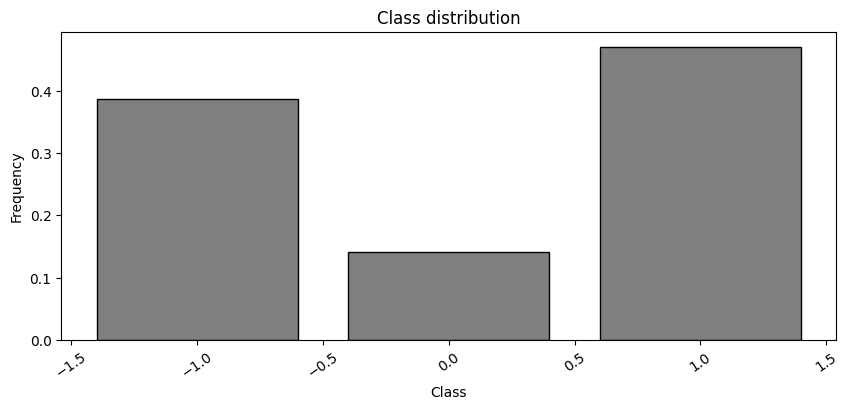

In [6]:
make_class_distribution_plot(data, class_variable, "Class distribution", display_desc=True)

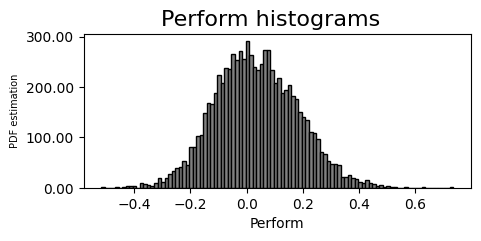

In [7]:
make_histograms(data, [perform_variable], "Perform histograms", display_desc=True, subplots_shape=(1, 1))

In [8]:
len(quant_variables)

116

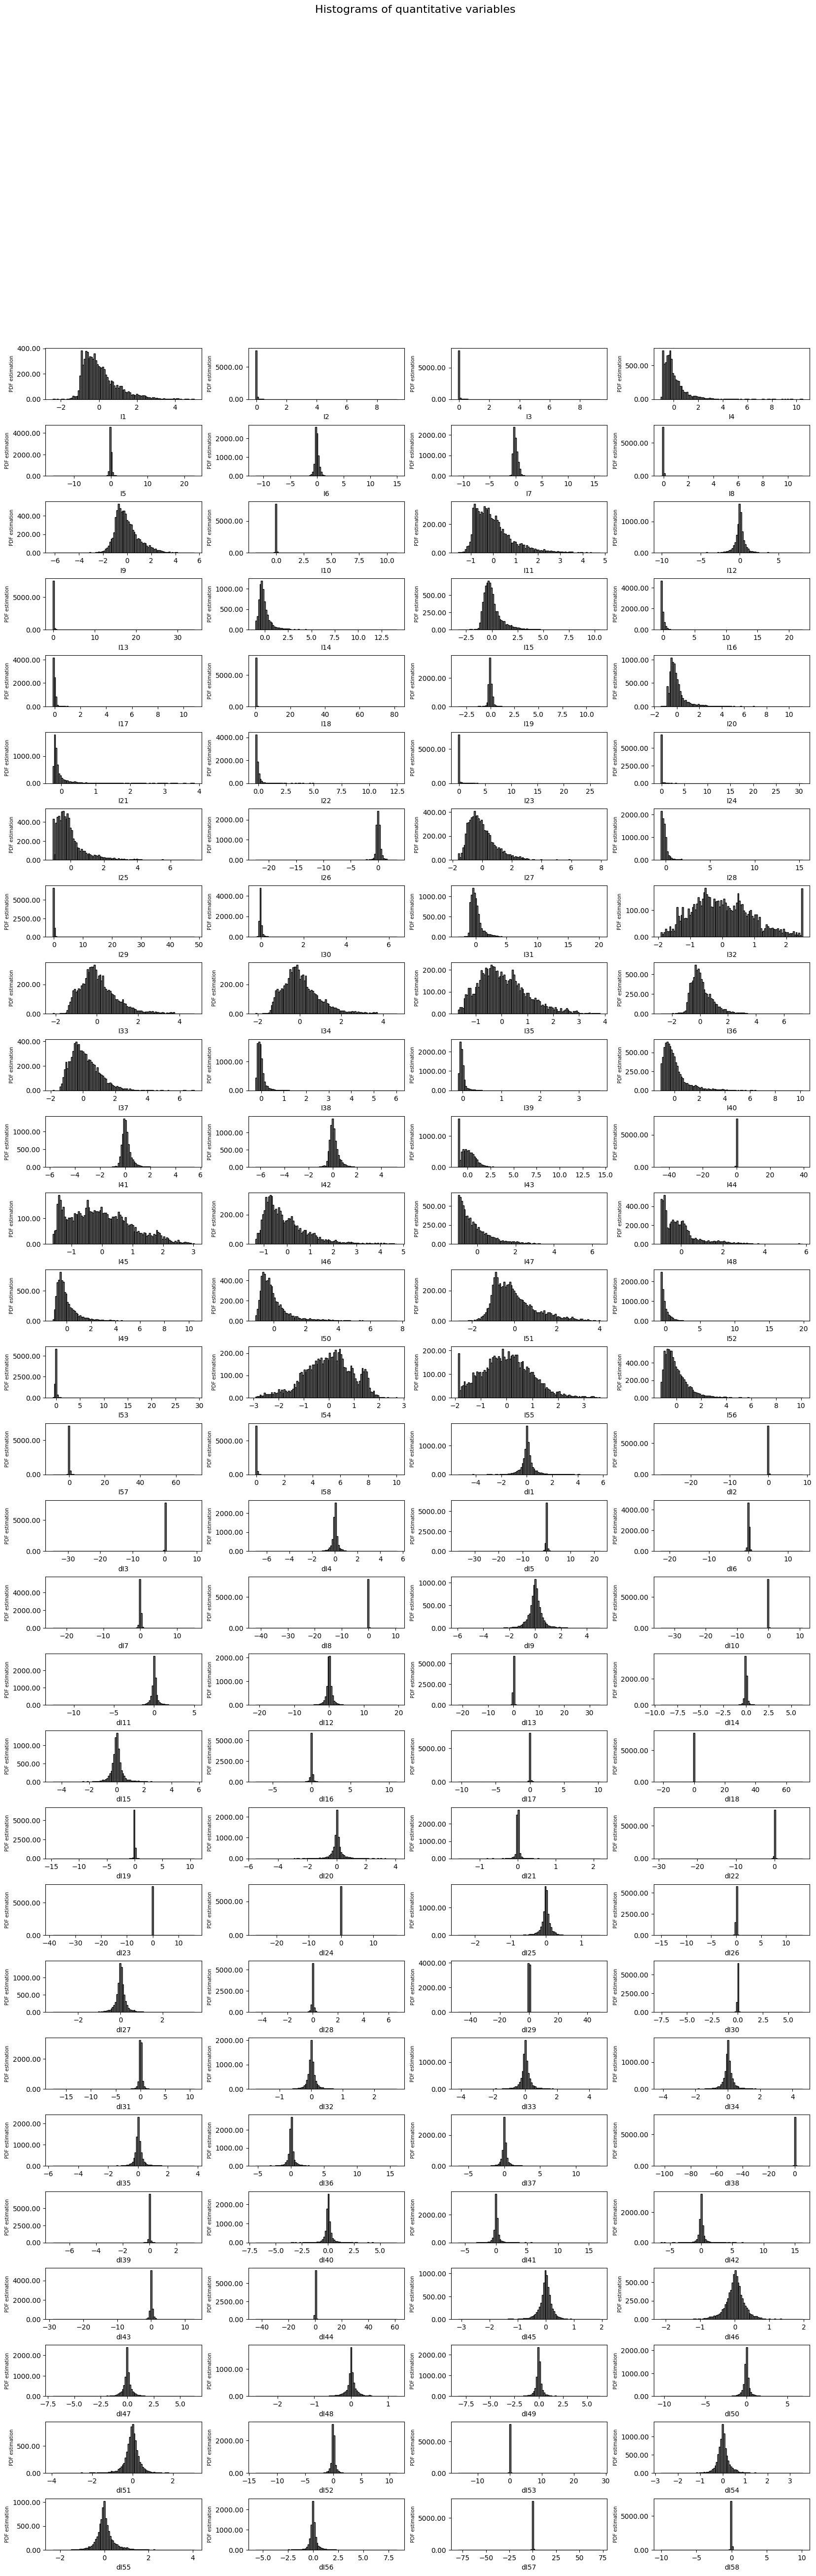

In [9]:
make_histograms(data, quant_variables, "Histograms of quantitative variables", display_desc=True, subplots_shape=(29, 4))

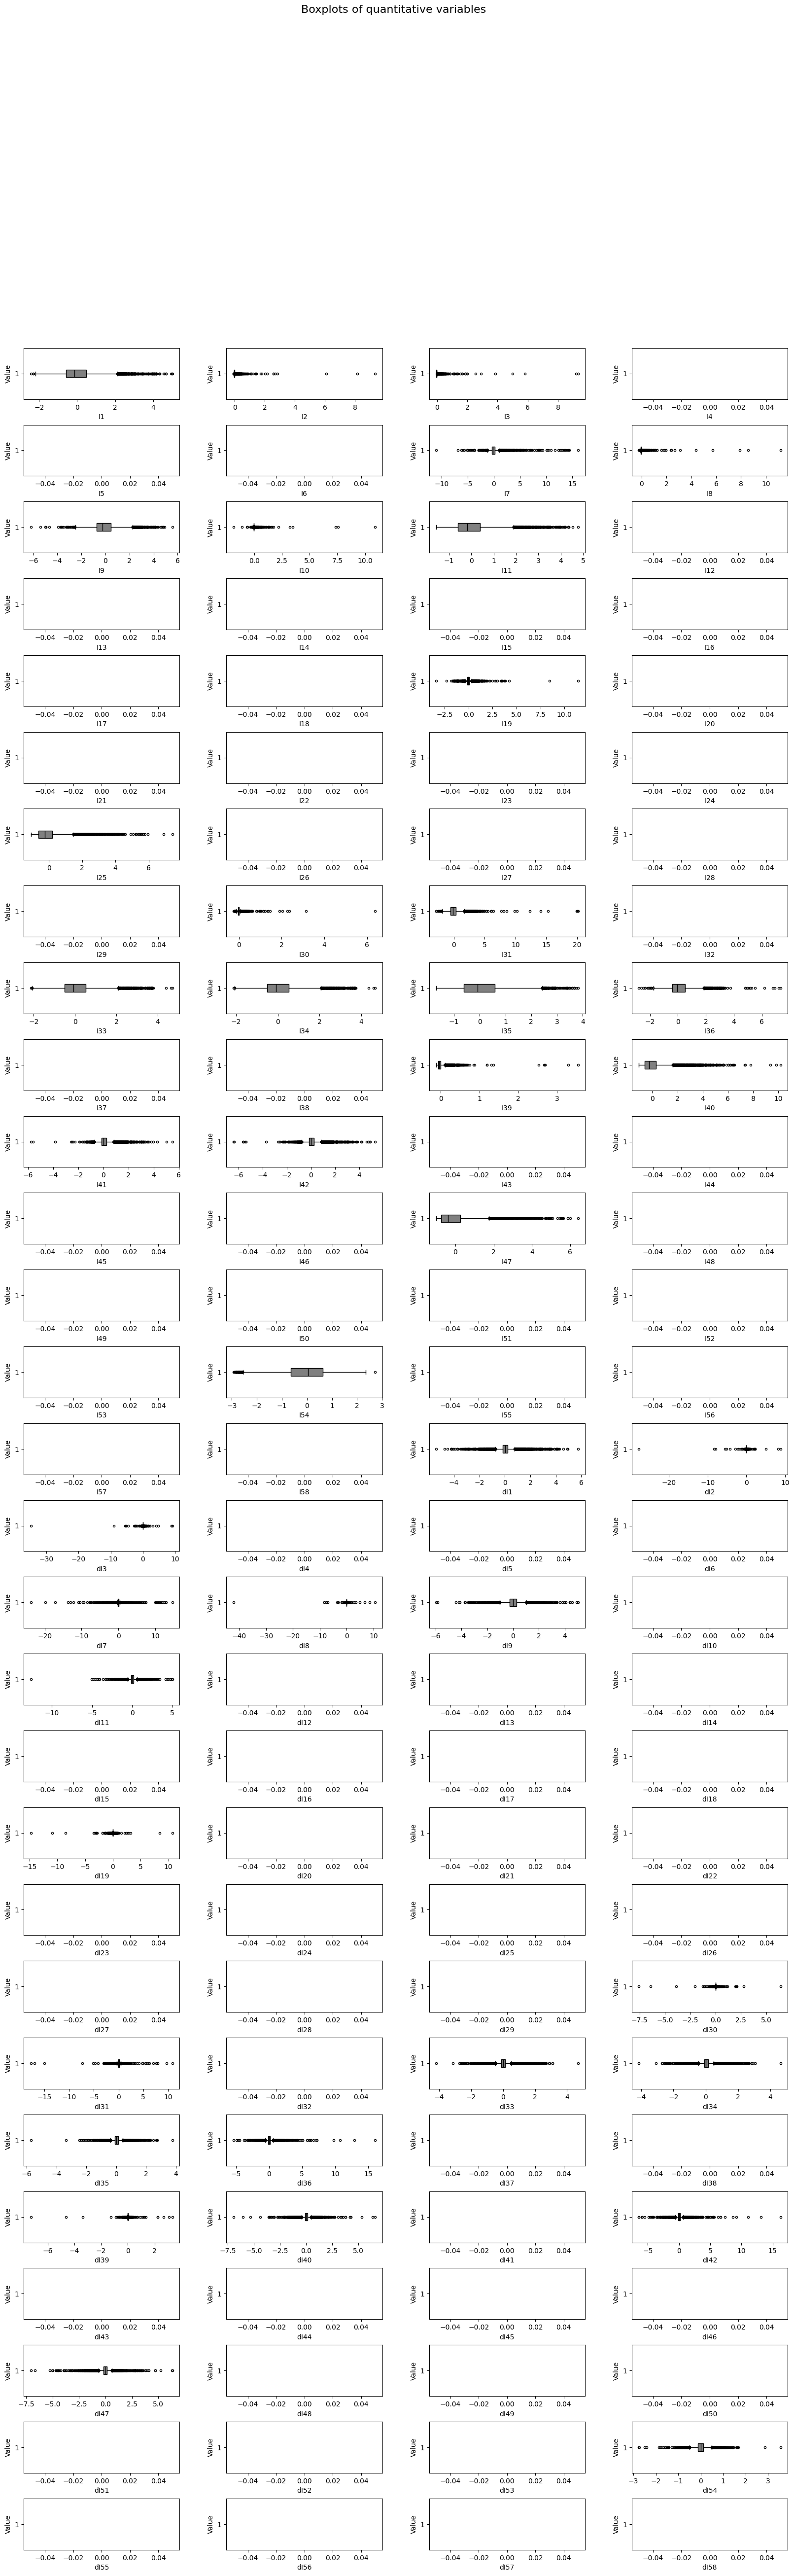

In [10]:
make_boxplots(data, quant_variables, "Boxplots of quantitative variables", display_desc=True, subplots_shape=(29, 4))

<Axes: >

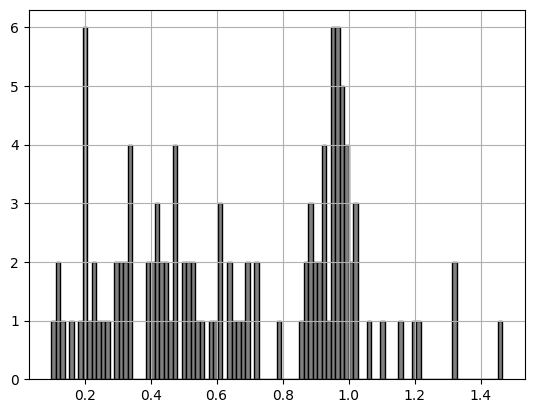

In [11]:
data[quant_variables].describe().loc['std'].hist(bins=100, color="grey", edgecolor="black")

In [12]:
data[quant_variables].describe()

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,I14,I15,I16,I17,I18,I19,I20,I21,I22,I23,I24,I25,I26,I27,I28,I29,I30,I31,I32,I33,I34,I35,I36,I37,I38,I39,I40,I41,I42,I43,I44,I45,I46,I47,I48,I49,I50,I51,I52,I53,I54,I55,I56,I57,I58,dI1,dI2,dI3,dI4,dI5,dI6,dI7,dI8,dI9,dI10,dI11,dI12,dI13,dI14,dI15,dI16,dI17,dI18,dI19,dI20,dI21,dI22,dI23,dI24,dI25,dI26,dI27,dI28,dI29,dI30,dI31,dI32,dI33,dI34,dI35,dI36,dI37,dI38,dI39,dI40,dI41,dI42,dI43,dI44,dI45,dI46,dI47,dI48,dI49,dI50,dI51,dI52,dI53,dI54,dI55,dI56,dI57,dI58
count,8000.000000,8000.000000,8000.000000,7475.000000,7995.000000,7999.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,7474.000000,7855.000000,7325.000000,7477.000000,7738.000000,7810.000000,7850.000000,8000.000000,7968.000000,6447.000000,7885.000000,7570.000000,7270.000000,8000.000000,7476.000000,7477.000000,7914.000000,7980.000000,8000.000000,8000.000000,7617.000000,8000.000000,8000.000000,8000.000000,8000.000000,7968.000000,7968.000000,8000.000000,8000.000000,8000.000000,8000.000000,7993.000000,7850.000000,7477.000000,7477.000000,8000.000000,6460.000000,7477.000000,6460.000000,7477.000000,7477.000000,7989.000000,8000.000000,7867.000000,7985.000000,7876.000000,7842.000000,8000.000000,8000.000000,8000.000000,7474.000000,7990.000000,7996.000000,8000.000000,8000.000000,8000.000000,7998.000000,8000.000000,7444.000000,7561.000000,7318.000000,7476.000000,7737.000000,7759.000000,7784.000000,8000.000000,7967.000000,6436.000000,7880.000000,7547.000000,7243.000000,7999.000000,7462.000000,7477.000000,7877.000000,7920.000000,8000.000000,8000.000000,7616.000000,8000.000000,8000.000000,8000.000000,8000.000000,7967.000000,7892.000000,8000.000000,8000.000000,7999.000000,8000.000000,7786.000000,7527.000000,7477.000000,7477.000000,8000.000000,6447.000000,7477.000000,6447.000000,7477.000000,7477.000000,7985.000000,8000.000000,7830.000000,7980.000000,7865.000000,7751.000000
mean,0.073392,-0.013688,-0.021178,0.005549,-0.012115,0.022632,0.019241,-0.024724,-0.046254,-0.007465,0.028291,-0.012260,-0.001943,-0.023128,0.037353,-0.005956,-0.019346,0.005870,-0.011018,0.014224,-0.018845,-0.047520,0.002350,0.005748,-0.022092,0.016557,0.015235,-0.024884,-0.007133,-0.015305,0.029474,0.022390,0.069011,0.069037,0.049915,0.114269,0.096127,-0.024247,-0.016165,0.024790,0.102648,0.099803,0.027615,0.009240,-0.041614,-0.034007,-0.089780,-0.014106,-0.010932,-0.014538,-0.020307,-0.007625,-0.026118,-0.012889,-0.008782,-0.018684,-0.009308,-0.013855,0.040376,-0.002199,-0.002639,-0.019874,-0.008650,-0.007810,-0.006543,-0.004330,-0.003595,-0.003942,0.008912,-0.012157,0.006406,-0.012467,-0.002947,0.000723,-0.002921,0.010385,-0.002442,0.009071,-0.001684,-0.006142,-0.007900,-0.003588,-0.017396,0.001348,0.009754,-0.004973,-0.000031,0.000187,0.023360,0.006215,0.027351,0.027060,0.025450,0.063110,0.063243,-0.020503,0.000432,0.024407,0.044030,0.043625,0.029518,0.005637,-0.034236,0.000740,-0.016921,-0.000769,-0.031485,-0.043165,-0.042074,-0.011027,0.010641,0.012687,0.015563,0.002955,0.003348,0.001651
std,0.905966,0.182037,0.199068,0.948536,0.986441,0.958664,0.970220,0.225448,1.016823,0.195737,0.868901,0.883932,0.614809,0.952196,0.975126,1.019368,0.222995,1.162974,0.305324,0.928410,0.406634,0.434037,0.895167,0.994890,0.949609,0.550486,0.999801,0.942948,0.851824,0.122001,1.026282,0.961682,0.890590,0.881130,0.928363,0.784892,0.874489,0.210560,0.112867,1.013860,0.477943,0.521476,0.951140,0.893439,0.988667,0.972939,0.928504,0.975429,0.981601,0.960804,0.992076,1.058885,0.471320,0.949530,0.963015,0.984594,0.904731,0.197337,0.651696,0.389082,0.453647,0.424185,1.325210,0.928424,0.964360,0.545322,0.664555,0.475173,0.513014,1.212350,0.722270,0.341694,0.503320,0.336200,0.256907,1.005356,0.311488,0.472219,0.098602,0.395784,0.688990,0.529040,0.196658,0.331755,0.301470,0.237254,1.106832,0.164248,0.579846,0.199843,0.426937,0.422402,0.333475,0.685889,0.608943,1.192374,0.139067,0.451708,0.637360,0.687366,0.637815,1.464854,0.329849,0.322753,0.608584,0.196637,0.530154,0.598254,0.418719,

# TODO - choose the variables for differences in inter class distribution

<Axes: xlabel='I1', ylabel='Density'>

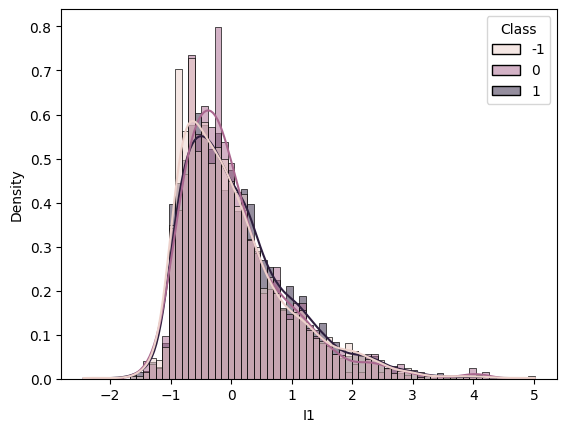

In [20]:
sns.histplot(data=data, x=quant_variables[0], hue=class_variable, kde=True, cumulative=False, stat="density", common_norm=False)